<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/crime_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 犯罪情報
- [町丁字別犯罪情報　令和３年分（累計値）](https://catalog.data.metro.tokyo.lg.jp/dataset/t000022d0000100001/resource/38bc69bc-3f83-4c70-af49-137c6b0db5e3)

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [5]:
output_master_file = 'crime_master.csv'
output_score_file = 'crime_score.csv'

In [6]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

In [7]:
crime_url = 'https://www.keishicho.metro.tokyo.lg.jp/about_mpd/jokyo_tokei/jokyo/ninchikensu.files/R3.csv'
df_crime = get_data_csv_url(crime_url, encoding='shift-jis')
print(df_crime.shape)

(5096, 38)


In [8]:
total_cols = [col for col in df_crime.columns if col.endswith('計')]
print(len(total_cols))

exclusion_rows = [row for row in list(df_crime['市区町丁'].unique()) if row.endswith('計')] + ['他県', '海外認知', '不明']
print(len(exclusion_rows))

6
67


In [9]:
df_crime_extract = df_crime[['市区町丁'] + total_cols]
df_crime_extract = df_crime_extract[~df_crime_extract['市区町丁'].isin(exclusion_rows)].reset_index(drop=True)
print(df_crime_extract.shape)

(5029, 7)


In [10]:
df_crime_extract['市区町村名'] = df_crime_extract['市区町丁'].str.extract('(^.*?[区市])', expand=False)
df_crime_ward = df_crime_extract[df_crime_extract['市区町村名'].fillna('').str.endswith('区')].reset_index(drop=True)
df_crime_ward['町丁目'] = df_crime_ward.apply(lambda x: x['市区町丁'].replace(x['市区町村名'], ''), axis=1)
print(df_crime_ward.shape)

assert df_crime_ward['市区町村名'].nunique() == 23

(3089, 9)


### 犯罪マスタ

In [11]:
df_crime_ward.to_csv(os.path.join(DIR_NAME, output_master_file), index=False)

### 人口マスタ

In [12]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目']]
print(df_pop_master.shape)

(3145, 4)


In [13]:
df_pop_master = pd.merge(
    df_pop_master, 
    df_crime_ward.drop(columns=['市区町丁']),
    on=['市区町村名', '町丁目'], how='left')
print(df_pop_master.shape)

(3145, 10)


In [14]:
df_pop_master.head()

,地域ID,市区町村名,町名,町丁目,総合計,凶悪犯計,粗暴犯計,侵入窃盗計,非侵入窃盗計,その他計
0,101003,千代田区,丸の内,丸の内１丁目,242.0,1.0,23.0,0.0,136.0,82.0
1,101004,千代田区,丸の内,丸の内２丁目,40.0,0.0,1.0,0.0,22.0,17.0
2,101005,千代田区,丸の内,丸の内３丁目,141.0,0.0,3.0,0.0,13.0,125.0
3,101007,千代田区,大手町,大手町１丁目,36.0,1.0,8.0,3.0,18.0,6.0
4,101008,千代田区,大手町,大手町２丁目,24.0,0.0,9.0,0.0,12.0,3.0


In [15]:
score_name = '治安スコア'
feature_list = {
    '凶悪犯計':     {'sort': -1, 'weight': 1}, 
    '粗暴犯計':     {'sort': -1, 'weight': 0.8},
    '侵入窃盗計':   {'sort': -1, 'weight': 0.6}, 
    '非侵入窃盗計': {'sort': -1, 'weight': 0.5}, 
    'その他計':     {'sort': -1, 'weight': 0.4}, 
}
all_feature_list = list(feature_list.keys())

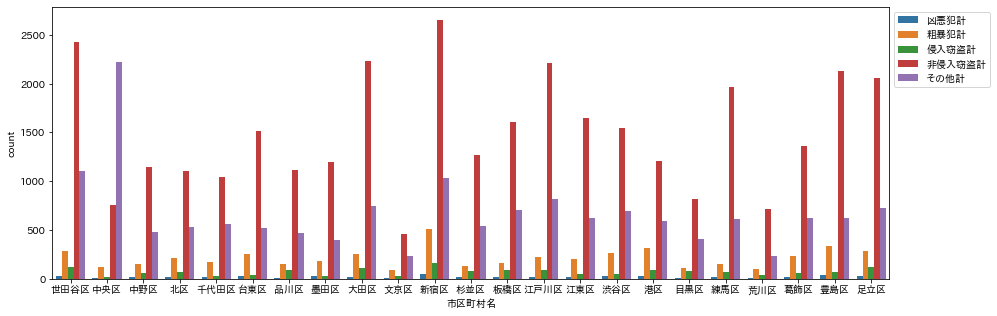

In [16]:
df_group_crime = df_pop_master.groupby('市区町村名')[all_feature_list].sum().stack().rename('count').reset_index()

plt.figure(figsize=(15, 5))
sns.barplot(data=df_group_crime, x='市区町村名', y='count', hue='level_1')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [17]:
# 犯罪件数がNaNの時は、平均値で埋める
for col in all_feature_list:
    df_pop_master[f'_{col}'] = df_pop_master[col]
    # 町名ごとの平均値
    df_pop_master[f'_{col}'] = df_pop_master[f'_{col}'].fillna(
        df_pop_master.groupby(['市区町村名', '町名'])[col].transform('mean').round(2)
    )
    # 区ごとの平均値
    df_pop_master[f'_{col}'] = df_pop_master[f'_{col}'].fillna(
        df_pop_master.groupby(['市区町村名'])[col].transform('mean').round(2)
    )

In [18]:
# 平均値で埋めたカラム
_feature_list = {}
for key, val in feature_list.items():
    _feature_list[f'_{key}'] = val
_all_feature_list = list(_feature_list.keys())

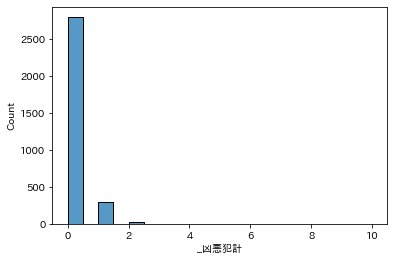

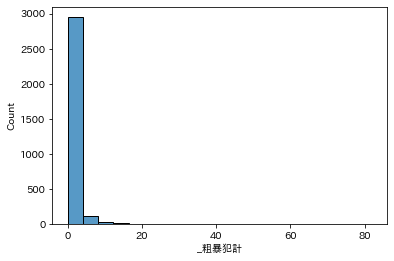

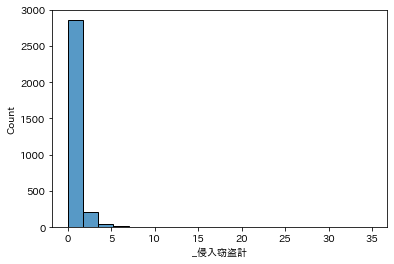

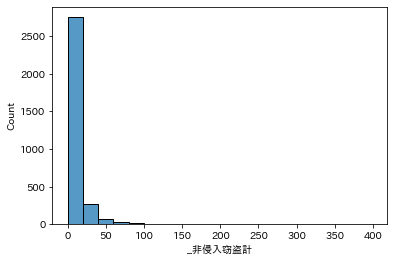

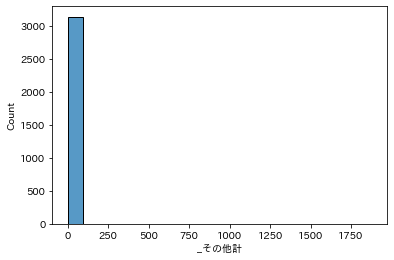

In [19]:
for feature_name in _all_feature_list:
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [20]:
import numpy as np
from scipy.stats import norm

def rank_score(sr_data):
    rank = sr_data.rank()
    count = rank.max() 
    x = (rank + 1)/(count + 1)
    max_val = 5
    y = norm.ppf(x, loc=0.5, scale=0.14)*max_val
    return np.clip(y, 0, max_val)

In [21]:
score_list = []
for key, value in _feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

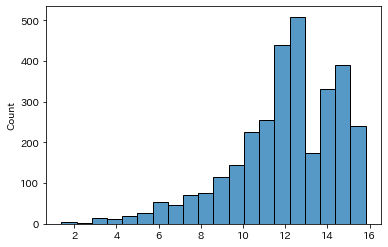

In [22]:
sns.histplot(_tmp_score, bins=20)
plt.show()

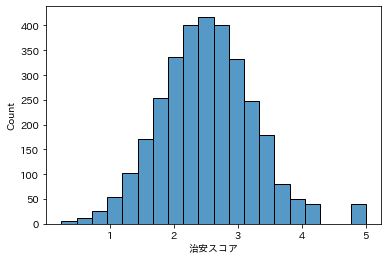

In [23]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [24]:
df_pop_master[score_name].describe()

count    3145.000000
mean        2.519780
std         0.732393
min         0.245573
25%         2.032251
50%         2.505611
75%         2.981875
max         5.000000
Name: 治安スコア, dtype: float64

### 保存

In [25]:
all_feature_list

['凶悪犯計', '粗暴犯計', '侵入窃盗計', '非侵入窃盗計', 'その他計']

In [26]:
df_pop_master[score_name] = df_pop_master[score_name].round(2)

In [27]:
df_pop_master[
    ['地域ID'] + all_feature_list + [score_name]
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

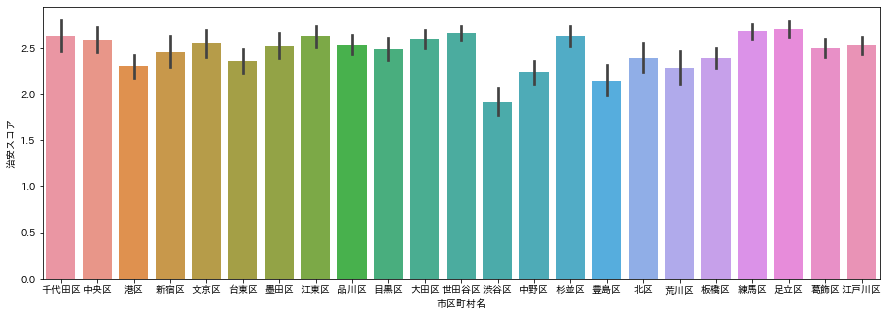

In [28]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_pop_master)
plt.show()

In [29]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')['治安スコア'].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values('治安スコア', ascending=False)[
     ['市区町村名', '町名', '町丁目'] + all_feature_list + [score_name]
].reset_index(drop=True)
print(df_level.shape)

(884, 9)


In [30]:
df_level.head(10)

,市区町村名,町名,町丁目,凶悪犯計,粗暴犯計,侵入窃盗計,非侵入窃盗計,その他計,治安スコア
0,墨田区,千歳,千歳１丁目,0.0,0.0,0.0,1.0,0.0,5.0
1,墨田区,東墨田,東墨田１丁目,0.0,0.0,0.0,1.0,0.0,5.0
2,北区,昭和町,昭和町３丁目,0.0,0.0,0.0,1.0,0.0,5.0
3,台東区,谷中,谷中１丁目,0.0,0.0,0.0,1.0,0.0,5.0
4,江戸川区,松江,松江６丁目,0.0,0.0,0.0,1.0,0.0,5.0
5,足立区,西加平,西加平１丁目,0.0,0.0,0.0,1.0,0.0,5.0
6,豊島区,駒込,駒込５丁目,0.0,0.0,0.0,1.0,0.0,5.0
7,世田谷区,瀬田,瀬田１丁目,0.0,0.0,0.0,1.0,0.0,5.0
8,足立区,花畑,花畑７丁目,0.0,0.0,0.0,1.0,0.0,5.0
9,港区,白金,白金４丁目,0.0,0.0,0.0,1.0,0.0,5.0


In [31]:
df_level.tail(10)

,市区町村名,町名,町丁目,凶悪犯計,粗暴犯計,侵入窃盗計,非侵入窃盗計,その他計,治安スコア
874,新宿区,榎町,榎町,NaN,NaN,NaN,NaN,NaN,1.17
875,新宿区,北山伏町,北山伏町,NaN,NaN,NaN,NaN,NaN,1.17
876,新宿区,戸塚町,戸塚町１丁目,NaN,NaN,NaN,NaN,NaN,1.17
877,新宿区,市谷船河原町,市谷船河原町,NaN,NaN,NaN,NaN,NaN,1.17
878,板橋区,幸町,幸町,2.0,2.0,1.0,19.0,6.0,1.12
879,板橋区,大山東町,大山東町,1.0,2.0,3.0,30.0,15.0,1.07
880,渋谷区,宇田川町,宇田川町,2.0,47.0,0.0,211.0,54.0,1.00
881,渋谷区,円山町,円山町,4.0,15.0,1.0,35.0,11.0,0.83
882,渋谷区,道玄坂,道玄坂１丁目,2.0,37.0,2.0,82.0,45.0,0.72
883,新宿区,歌舞伎町,歌舞伎町２丁目,10.0,69.0,22.0,190.0,69.0,0.33
